ImageNet

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths
TRAIN_PATH = '/content/drive/MyDrive/data/train'
VALID_PATH = '/content/drive/MyDrive/data/valid'
TEST_PATH = '/content/drive/MyDrive/data/test'

# Image parameters
TARGET_SIZE = (224, 224)  # ResNet50 expects 224x224 images
BATCH_SIZE = 32
NUM_CLASSES = 6

# Class names for better readability
class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}


In [ ]:
def read_annotation_file(file_path):
    """
    Read and parse annotation file into a DataFrame
    Expected format per line: image_name x_min,y_min,x_max,y_max,class_id
    """
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int, parts[1].split(',')))
                if len(bbox) != 5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(
        annotations,
        columns=['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_id']
    )


In [ ]:
def preprocess_image(image_path):
    """
    Load and preprocess a single image.
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, TARGET_SIZE)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocess as per ResNet50
    return image


In [ ]:
def prepare_dataset(annotations_df, base_path):
    """
    Prepare dataset by loading and preprocessing images and labels.
    """
    images = []
    labels = []

    for _, row in annotations_df.iterrows():
        image_path = os.path.join(base_path, row['image_name'])
        image = preprocess_image(image_path)
        if image is not None:
            images.append(image)
            labels.append(row['class_id'])

    images = np.array(images)
    labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)
    return images, labels


In [ ]:
def display_sample_images(images, labels, num_samples=5):
    """
    Display a few sample images with their labels.
    """
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        img = images[idx].astype('float32')
        # Reverse the preprocess_input for visualization
        img = tf.keras.applications.resnet50.decode_predictions(np.expand_dims(img, axis=0))[0][0][1]
        plt.imshow(images[idx].astype('float32') / 255.0)
        plt.title(f"Label: {class_names[np.argmax(labels[idx])]}")
        plt.axis('off')
    plt.show()


In [ ]:
print("Loading annotation files...")
train_annotations = read_annotation_file(os.path.join(TRAIN_PATH, '_annotations.txt'))
valid_annotations = read_annotation_file(os.path.join(VALID_PATH, '_annotations.txt'))
test_annotations = read_annotation_file(os.path.join(TEST_PATH, '_annotations.txt'))

print("Preparing datasets...")
X_train, y_train = prepare_dataset(train_annotations, TRAIN_PATH)
X_val, y_val = prepare_dataset(valid_annotations, VALID_PATH)
X_test, y_test = prepare_dataset(test_annotations, TEST_PATH)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Optional: Display sample images
# display_sample_images(X_train, y_train)


Loading annotation files...
Preparing datasets...
Training set shape: (11948, 224, 224, 3)
Validation set shape: (1922, 224, 224, 3)
Test set shape: (985, 224, 224, 3)


In [ ]:
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [ ]:
def create_imagenet_model():
    """
    Create a model based on ResNet50 pretrained on ImageNet,
    adapted for the specific classification task.
    """
    # Load ResNet50 with ImageNet weights, excluding top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base_model initially
    base_model.trainable = False

    # Add custom layers on top of ResNet50
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reduce dimensionality
    x = Dense(1024, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.5)(x)  # Dropout for regularization
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer for 6 classes

    # Define the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
model = create_imagenet_model()
model.summary()  # Optional: View model architecture


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,692,038 (98.01 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    ModelCheckpoint('best_imagenet_model.keras', save_best_only=True, monitor='val_loss')
]


In [ ]:
history = model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 154s 363ms/step - accuracy: 0.5862 - loss: 1.5411 - val_accuracy: 0.8262 - val_loss: 0.4934 - learning_rate: 0.0010
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 121s 317ms/step - accuracy: 0.7417 - loss: 0.6844 - val_accuracy: 0.8590 - val_loss: 0.4293 - learning_rate: 0.0010
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 120s 315ms/step - accuracy: 0.7742 - loss: 0.6144 - val_accuracy: 0.8736 - val_loss: 0.3815 - learning_rate: 0.0010
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 121s 318ms/step - accuracy: 0.7991 - loss: 0.5567 - val_accuracy: 0.8762 - val_loss: 0.3631 - learning_rate: 0.0010
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 120s 316ms/step - accuracy: 0.7906 - loss: 0.5665 - val_accuracy: 0.8710 - val_loss: 0.3672 - learning_rate: 0.0010
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 121s 318ms/step - accuracy: 0.7972 - loss: 0.5502 - val_accuracy: 0.8897 - val_loss: 0.3496 - learning_rate: 0.0010
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 120s 316ms/step - accuracy: 0.7986 

In [ ]:
# Unfreeze the last 50 layers of the model
for layer in model.layers[:-50]:
    layer.trainable = False

for layer in model.layers[-50:]:
    layer.trainable = True


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Continue training
fine_tune_epochs = 10
total_epochs = 20 + fine_tune_epochs  # Total number of epochs including fine-tuning

history_fine = model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Continue from the last epoch of previous training
    validation_data=(X_val, y_val),
    callbacks=callbacks  # Callbacks like EarlyStopping, ModelCheckpoint, etc.
)

Epoch 20/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 167s 367ms/step - accuracy: 0.7407 - loss: 0.7334 - val_accuracy: 0.9168 - val_loss: 0.2824 - learning_rate: 1.0000e-05
Epoch 21/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 122s 321ms/step - accuracy: 0.8783 - loss: 0.3527 - val_accuracy: 0.9230 - val_loss: 0.2660 - learning_rate: 1.0000e-05
Epoch 22/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 122s 320ms/step - accuracy: 0.8972 - loss: 0.3114 - val_accuracy: 0.9303 - val_loss: 0.2364 - learning_rate: 1.0000e-05
Epoch 23/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 121s 317ms/step - accuracy: 0.9146 - loss: 0.2659 - val_accuracy: 0.9308 - val_loss: 0.2258 - learning_rate: 1.0000e-05
Epoch 24/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 123s 322ms/step - accuracy: 0.9221 - loss: 0.2319 - val_accuracy: 0.9381 - val_loss: 0.2129 - learning_rate: 1.0000e-05
Epoch 25/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 120s 314ms/step - accuracy: 0.9316 - loss: 0.2003 - val_accuracy: 0.9422 - val_loss: 0.2238 - learning_rate: 1.0000e-05
Epoch 26/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 122s 

In [ ]:
# Print the layer names of the model
for layer in model.layers:
    print(layer.name)


input_layer_3
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models


In [ ]:
# Freeze all layers except the last 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Ensure the last 50 layers are trainable
for layer in base_model.layers[-50:]:
    layer.trainable = True


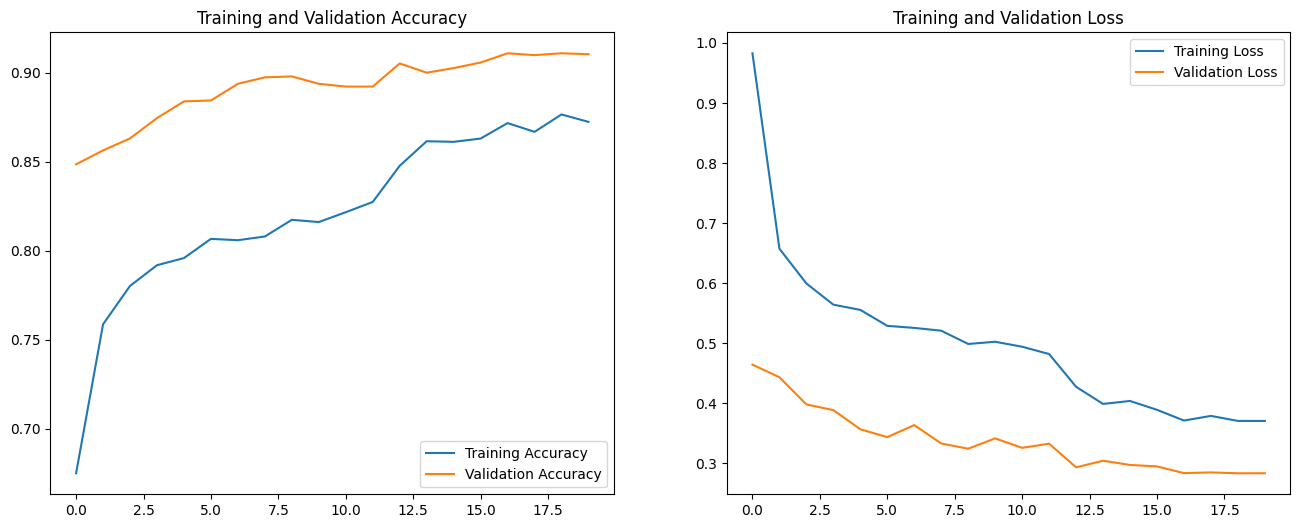

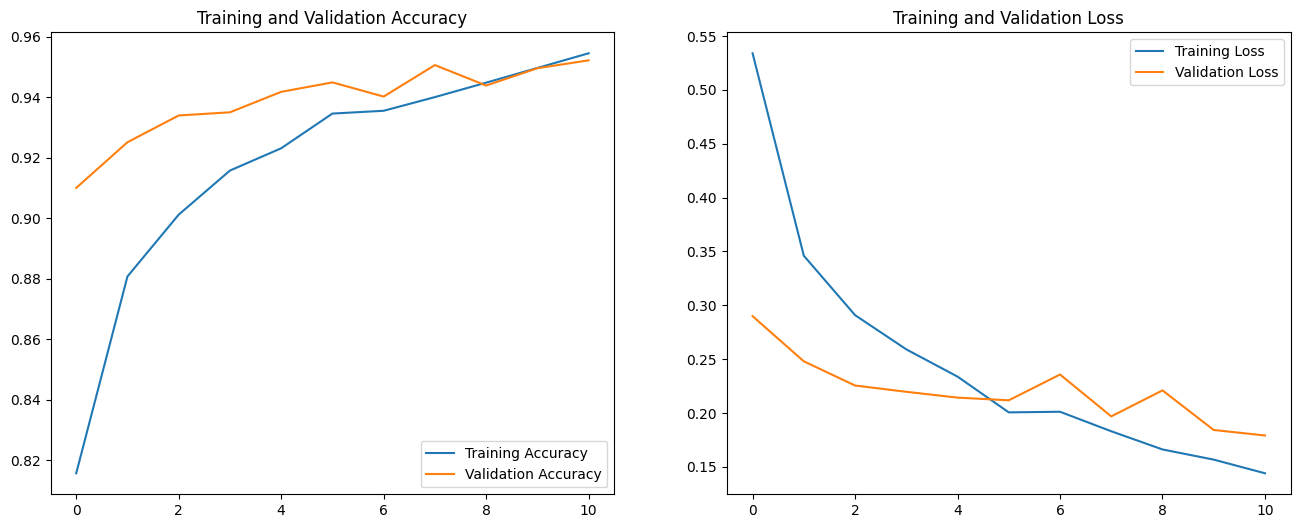

In [ ]:
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Plot initial training
plot_training_history(history)

# If fine-tuning was performed, plot fine-tuning history
if 'history_fine' in locals():
    plot_training_history(history_fine)


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")


31/31 - 6s - 178ms/step - accuracy: 0.9462 - loss: 0.1946
Test Accuracy: 0.9462


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


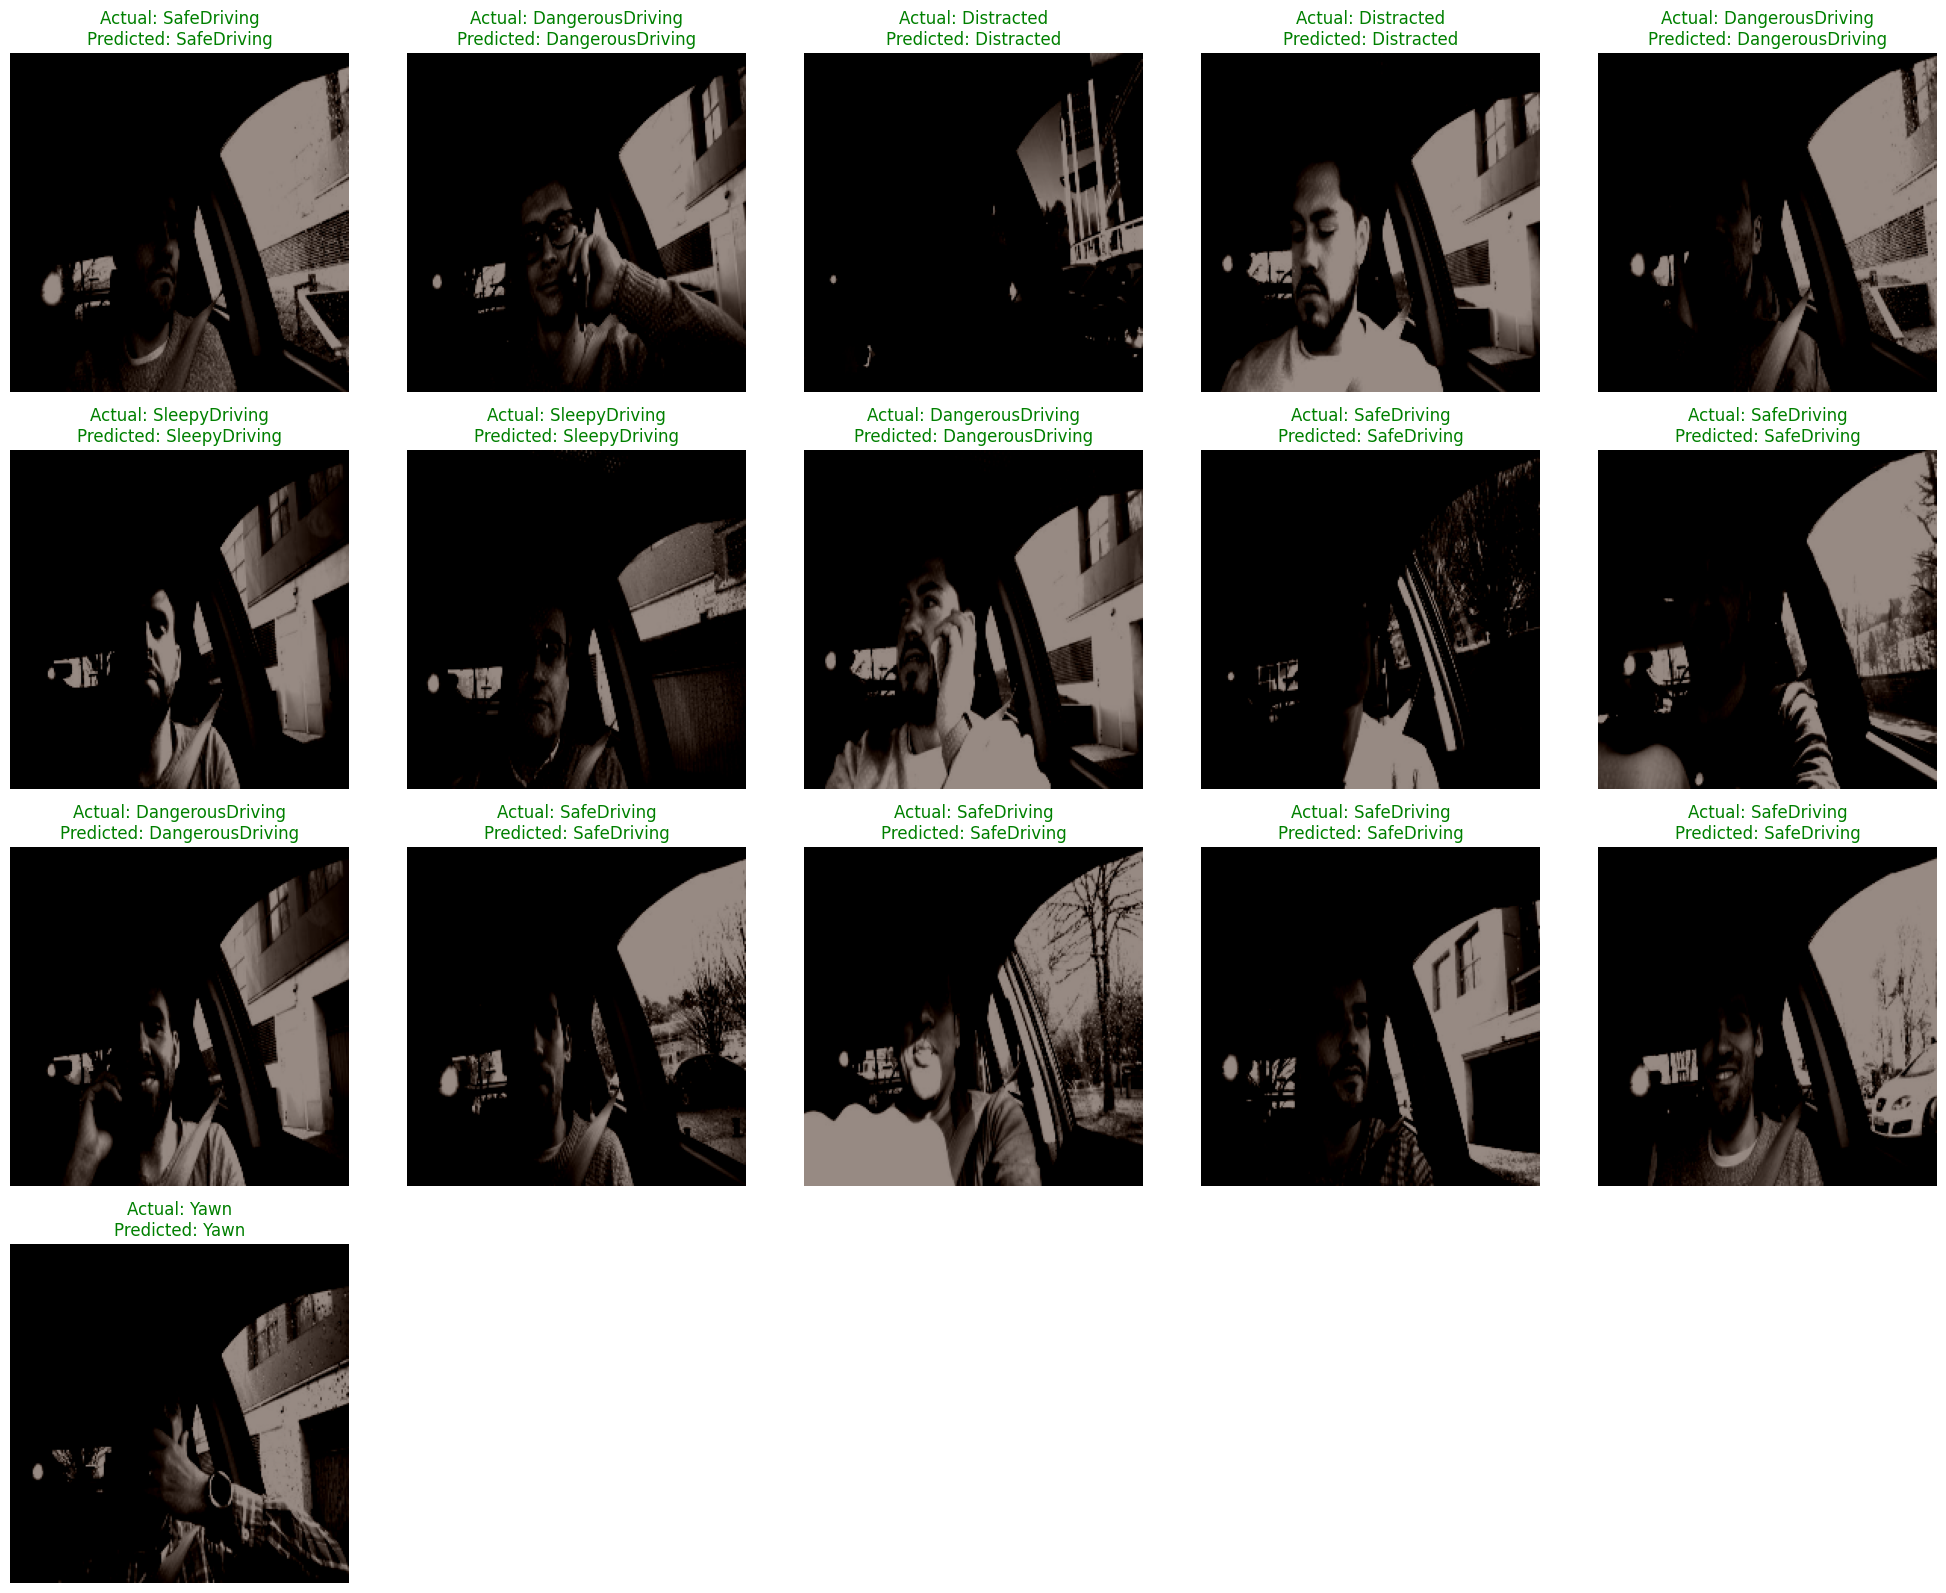

In [ ]:
def plot_predictions(model, test_images, test_labels, num_samples=16):
    """
    Plot sample predictions alongside actual labels.
    """
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    sample_images = test_images[indices]
    sample_labels = test_labels[indices]
    predictions = model.predict(sample_images)

    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        plt.subplot(int(np.sqrt(num_samples)) + 1, int(np.sqrt(num_samples)) + 1, i+1)
        plt.imshow(sample_images[i].astype('float32') / 255.0)
        actual = class_names[np.argmax(sample_labels[i])]
        predicted = class_names[np.argmax(predictions[i])]
        color = 'green' if actual == predicted else 'red'
        plt.title(f"Actual: {actual}\nPredicted: {predicted}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
plot_predictions(model, X_test, y_test)


In [ ]:
model.save('/content/drive/MyDrive/model/driver_attention_model_resnet50.h5')
print("Model saved successfully.")


Model saved successfully.


In [ ]:
# -*- coding: utf-8 -*-
"""imgDriverDrowsiness_with_tuning.ipynb"""

import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt  # Keras Tuner for hyperparameter optimization

# Paths
TRAIN_PATH = '/content/drive/MyDrive/data/train'
VALID_PATH = '/content/drive/MyDrive/data/valid'
TEST_PATH = '/content/drive/MyDrive/data/test'

# Parameters
TARGET_SIZE = (224, 224)
NUM_CLASSES = 6
BATCH_SIZE = 32

# Class names
class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

# Functions for annotations and preprocessing
def read_annotation_file(file_path):
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int, parts[1].split(',')))
                if len(bbox) != 5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(
        annotations,
        columns=['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_id']
    )

def preprocess_image(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

def prepare_dataset(annotations_df, base_path):
    images, labels = [], []
    for _, row in annotations_df.iterrows():
        image_path = os.path.join(base_path, row['image_name'])
        image = preprocess_image(image_path)
        if image is not None:
            images.append(image)
            labels.append(row['class_id'])
    images = np.array(images)
    labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)
    return images, labels

# Load datasets
train_annotations = read_annotation_file(os.path.join(TRAIN_PATH, '_annotations.txt'))
valid_annotations = read_annotation_file(os.path.join(VALID_PATH, '_annotations.txt'))
test_annotations = read_annotation_file(os.path.join(TEST_PATH, '_annotations.txt'))

X_train, y_train = prepare_dataset(train_annotations, TRAIN_PATH)
X_val, y_val = prepare_dataset(valid_annotations, VALID_PATH)
X_test, y_test = prepare_dataset(test_annotations, TEST_PATH)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Data Augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Hyperparameter tuning with Keras Tuner
def model_builder(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model

    x = GlobalAveragePooling2D()(base_model.output)
    units = hp.Int('units', min_value=512, max_value=1024, step=128)
    x = Dense(units, activation='relu')(x)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Keras Tuner Hyperband
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='driver_drowsiness_tuning'
)

stop_early = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    data_augmentation.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    callbacks=[stop_early]
)

# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in dense layer is {best_hps.get('units')},
the optimal dropout rate is {best_hps.get('dropout_rate')},
and the optimal learning rate is {best_hps.get('learning_rate')}.
""")


In [ ]:
ModelCheckpoint('best_tuned_model.h5', save_best_only=True, monitor='val_loss', save_format='h5')


In [ ]:


# Unfreeze the last 50 layers for fine-tuning
base_model = model.layers[0]  # Extract base model
for layer in base_model.layers[:-50]:
    layer.trainable = False

for layer in base_model.layers[-50:]:
    layer.trainable = True

# Re-compile the model for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_epochs = 10
history_fine = model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=fine_tune_epochs,
    initial_epoch=history.epoch[-1],  # Continue from the last epoch of previous training
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
        ModelCheckpoint('fine_tuned_model.h5', save_best_only=True, monitor='val_loss')
    ]
)

# Evaluate the tuned model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the final model
model.save('/content/drive/MyDrive/model/driver_attention_tuned_model_resnet50.h5')
print("Tuned model saved successfully.")

# Plot the training history for visualization
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)

# If fine-tuning was performed, plot fine-tuning history
if 'history_fine' in locals():
    plot_training_history(history_fine)

# Visualize predictions on test set
def plot_predictions(model, test_images, test_labels, num_samples=16):
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    sample_images = test_images[indices]
    sample_labels = test_labels[indices]
    predictions = model.predict(sample_images)

    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        plt.subplot(int(np.sqrt(num_samples)) + 1, int(np.sqrt(num_samples)) + 1, i+1)
        plt.imshow(sample_images[i].astype('float32') / 255.0)
        actual = class_names[np.argmax(sample_labels[i])]
        predicted = class_names[np.argmax(predictions[i])]
        color = 'green' if actual == predicted else 'red'
        plt.title(f"Actual: {actual}\nPredicted: {predicted}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
plot_predictions(model, X_test, y_test)


MobileNet

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.5279 - loss: 1.2862 - val_accuracy: 0.7908 - val_loss: 0.6068
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7324 - loss: 0.7233 - val_accuracy: 0.8184 - val_loss: 0.5265
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7687 - loss: 0.6318 - val_accuracy: 0.8538 - val_loss: 0.4463
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7870 - loss: 0.5711 - val_accuracy: 0.8476 - val_loss: 0.4524
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8053 - loss: 0.5353 - val_accuracy: 0.8668 - val_loss: 0.4021
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8160 - loss: 0.5115 - val_accuracy: 0.8772 - val_loss: 0.3846
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8261 - loss: 0.4917 - val_accuracy: 0.8762 - val_loss: 0.3914
Epoch 8/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step -

Test accuracy: 0.8853


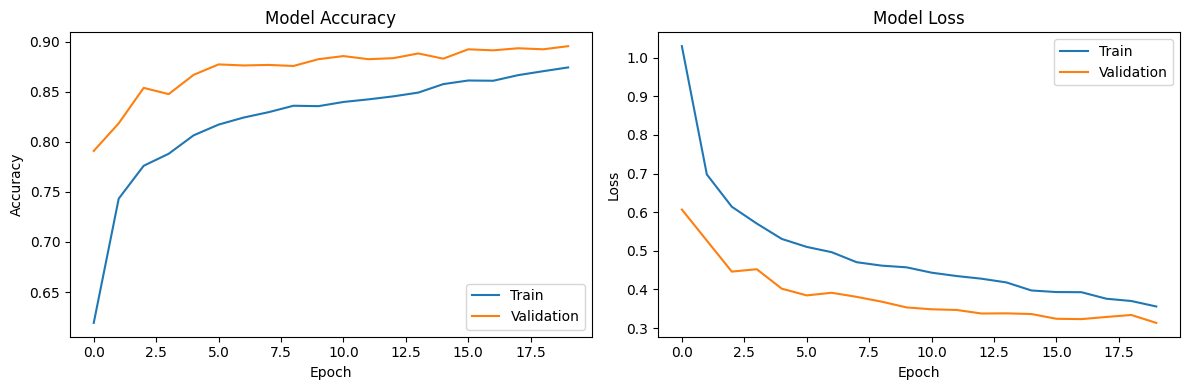

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


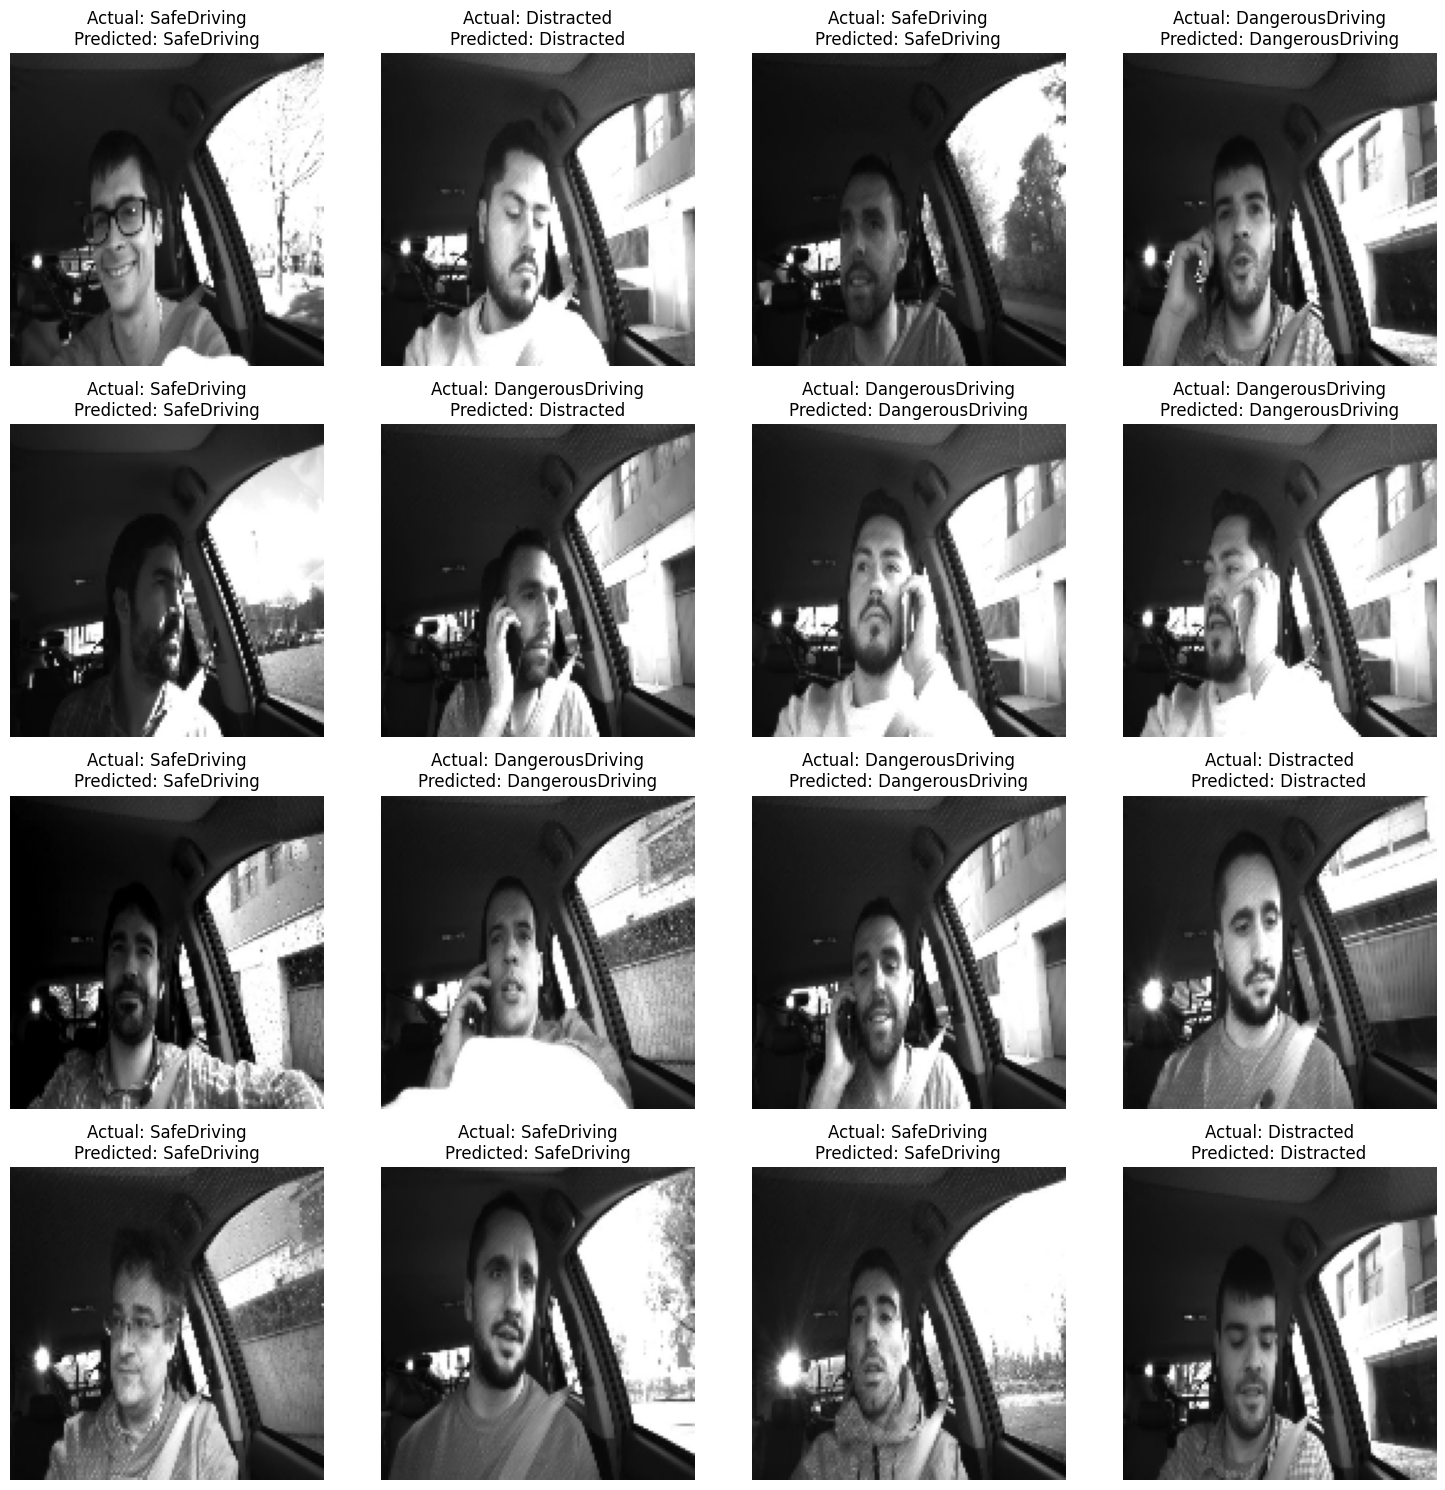

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder
import cv2
import matplotlib.pyplot as plt

# Define constants
TRAIN_PATH = '/content/drive/MyDrive/data/train'
VALID_PATH = '/content/drive/MyDrive/data/valid'
TEST_PATH = '/content/drive/MyDrive/data/test'
TARGET_SIZE = (128, 128)  # Resize images to fit MobileNet input
BATCH_SIZE = 32
NUM_CLASSES = 6

# Define class names for readability
class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

# Helper function to read annotation files
def read_annotation_file(file_path):
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int, parts[1].split(',')))
                if len(bbox) != 5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(
        annotations,
        columns=['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_id']
    )

# Preprocess and normalize images
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)
    return image / 255.0  # Normalize pixel values

# Prepare dataset by loading and processing images
def prepare_dataset(annotations_df, base_path):
    images = []
    labels = []

    for _, row in annotations_df.iterrows():
        image_path = os.path.join(base_path, row['image_name'])
        image = preprocess_image(image_path)
        images.append(image)
        labels.append(row['class_id'])

    images = np.array(images)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False)
    labels = np.array(labels).reshape(-1, 1)
    labels = encoder.fit_transform(labels)

    return images, labels

# Load and visualize the data
train_annotations = read_annotation_file(os.path.join(TRAIN_PATH, '_annotations.txt'))
valid_annotations = read_annotation_file(os.path.join(VALID_PATH, '_annotations.txt'))
test_annotations = read_annotation_file(os.path.join(TEST_PATH, '_annotations.txt'))

X_train, y_train = prepare_dataset(train_annotations, TRAIN_PATH)
X_val, y_val = prepare_dataset(valid_annotations, VALID_PATH)
X_test, y_test = prepare_dataset(test_annotations, TEST_PATH)

# Data Augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

# Define MobileNetV2 model architecture
def create_mobilenet_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

    # Freeze the layers of MobileNetV2
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of MobileNetV2
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Add dropout layer for regularization
    x = Dense(512, activation='relu')(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Display example images
def display_sample_images(images, labels, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {np.argmax(labels[idx])}")
        plt.axis('off')
    plt.show()

# Create the MobileNetV2 model
model = create_mobilenet_model()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Save the model
model.save('mobilenet_driver_attention_model.h5')

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Visualizing predictions
def plot_predictions(model, test_images, test_labels, num_samples=16):
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    sample_images = test_images[indices]
    sample_labels = test_labels[indices]
    predictions = model.predict(sample_images)

    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for idx, ax in enumerate(axes.flat):
        ax.imshow(sample_images[idx])
        actual = class_names[np.argmax(sample_labels[idx])]
        predicted = class_names[np.argmax(predictions[idx])]
        ax.set_title(f'Actual: {actual}\nPredicted: {predicted}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions
plot_predictions(model, X_test, y_test)


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_mobilenet.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max')
]


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 65s 140ms/step - accuracy: 0.3626 - loss: 2.1411 - val_accuracy: 0.6670 - val_loss: 0.9089 - learning_rate: 1.0000e-04
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - accuracy: 0.5829 - loss: 1.2254 - val_accuracy: 0.7310 - val_loss: 0.7600 - learning_rate: 1.0000e-04
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.6261 - loss: 1.0784 - val_accuracy: 0.7617 - val_loss: 0.6997 - learning_rate: 1.0000e-04
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - accuracy: 0.6578 - loss: 0.9823 - val_accuracy: 0.7617 - val_loss: 0.6805 - learning_rate: 1.0000e-04
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.6655 - loss: 0.9379 - val_accuracy: 0.7804 - val_loss: 0.6340 - learning_rate: 1.0000e-04
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - accuracy: 0.6735 - loss: 0.8848 - val_accuracy: 0.7924 - val_loss: 0.6050 - learning_rate: 1.0000e-04
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - 

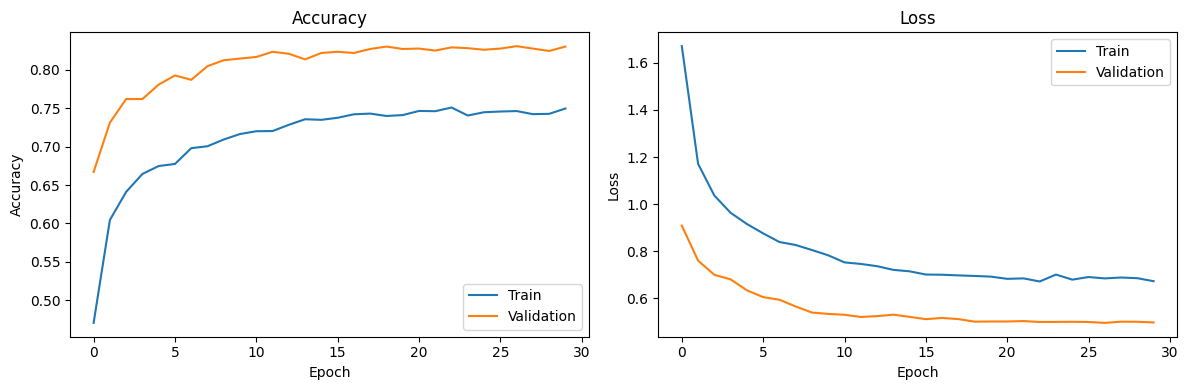

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step


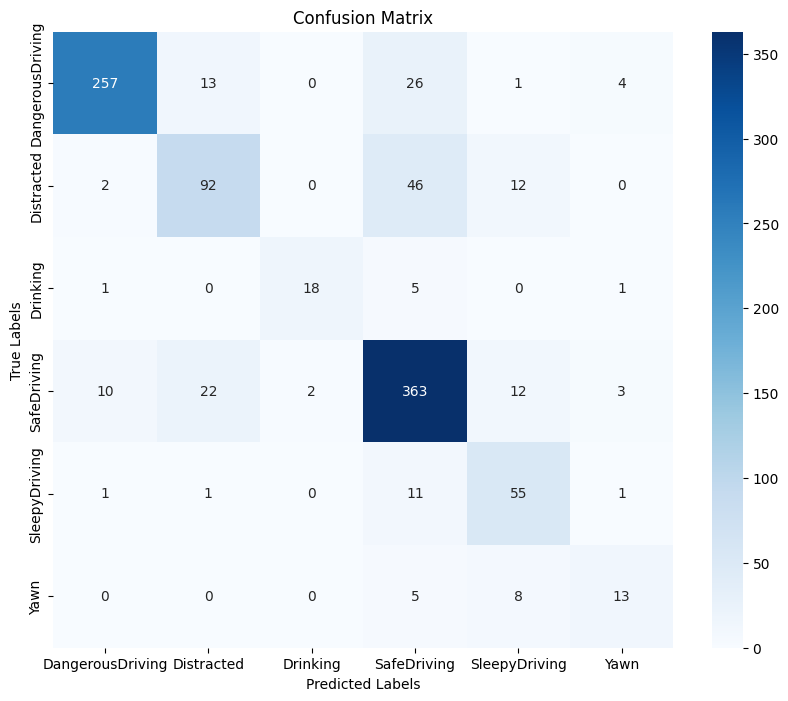

                  precision    recall  f1-score   support

DangerousDriving       0.95      0.85      0.90       301
      Distracted       0.72      0.61      0.66       152
        Drinking       0.90      0.72      0.80        25
     SafeDriving       0.80      0.88      0.84       412
   SleepyDriving       0.62      0.80      0.70        69
            Yawn       0.59      0.50      0.54        26

        accuracy                           0.81       985
       macro avg       0.76      0.73      0.74       985
    weighted avg       0.82      0.81      0.81       985



In [ ]:

history = model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plot_confusion_matrix(cm, list(class_names.values()))

print(classification_report(y_true_classes, y_pred_classes, target_names=list(class_names.values())))
